# Imports

## Packages

In [3]:
import os
import pandas as pd
import numpy as np
import random
import importlib
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, LeavePGroupsOut, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pylab import *
import seaborn as sns
import tensorflow as tf
from scipy import stats
from mlxtend.evaluate import paired_ttest_5x2cv

pd.set_option("display.max_rows", None, "display.max_columns", None)
plt.rcParams['figure.facecolor']='white'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Helpers

In [4]:
import sys
sys.path.append("../")

# glove preprocessings
import Helpers.Glove_transform
importlib.reload(Helpers.Glove_transform)
from Helpers.Glove_transform import GloveTransform

# Stanford tokenizer
import Helpers.Stanford_Tokenizer
importlib.reload(Helpers.Stanford_Tokenizer)
from Helpers.Stanford_Tokenizer import StanfordTokenizer

# Tweet tokenizer(from C-BiGRU paper)
import Helpers.Tweet_Tokenizer
importlib.reload(Helpers.Tweet_Tokenizer)
from Helpers.Tweet_Tokenizer import TweetTokenize

# glove embeddings
import Helpers.Glove_twitter_embeddings
importlib.reload(Helpers.Glove_twitter_embeddings)
from Helpers.Glove_twitter_embeddings import GloveTwitterEmbeddings

# glove common crawl
import Helpers.Glove_CommonCrawl_embeddings
importlib.reload(Helpers.Glove_CommonCrawl_embeddings)
from Helpers.Glove_CommonCrawl_embeddings import GloveCommomCrawlEmbeddings

# Word embedding(from C-BiGRU paper)
import Helpers.Word2Vec_Twitter
importlib.reload(Helpers.Word2Vec_Twitter)
from Helpers.Word2Vec_Twitter import Word2VecTwitter

# Fasttext embedding
import Helpers.Fasttext_Twitter
importlib.reload(Helpers.Fasttext_Twitter)
from Helpers.Fasttext_Twitter import FasttextTwitter

# Padding
import Helpers.Padding
importlib.reload(Helpers.Padding)
from Helpers.Padding import Padding

# Kears sklearn CNN classifier
import Helpers.CNN_SciKeras_Classifier
importlib.reload(Helpers.CNN_SciKeras_Classifier)
from Helpers.CNN_SciKeras_Classifier import CNN_classifier

# Kears sklearn CBiGRU classifier
import Helpers.CBiGRU_SciKeras_Classifier
importlib.reload(Helpers.CBiGRU_SciKeras_Classifier)
from Helpers.CBiGRU_SciKeras_Classifier import CBiGRU_classifier

# Directory to store results

In [5]:
results_dir = Path('../../results/iddc_multi')
results_dir.mkdir(parents=True, exist_ok=True)

results_plot = Path('../../results/plots')
results_plot.mkdir(parents=True, exist_ok=True)

# Dataset

In [3]:
FourCVTweets = "../../Datasets/Incident-Related-Twitters/4CVTweets/"
data = pd.DataFrame(columns=["text", "label", "groups"])

for i, data_file in enumerate(os.listdir(FourCVTweets)):
    data_sample = pd.read_csv(FourCVTweets + data_file, delimiter=";", names=["text", "label"], encoding="ISO-8859-1")
    data_sample["groups"] = i
    data = pd.concat([data, data_sample], ignore_index=True)

x_train, y_train = data.text, data.label
groups = data.groups

print("Total number of datapoints in train set:",len(x_train))

Total number of datapoints in train set: 20457


In [4]:
# label encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train.values)

## Class weights

In [5]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train      
                                    )

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.3136037527593819,
 1: 2.0539156626506023,
 2: 4.07834928229665,
 3: 12.627777777777778}

# Experiments

## SVM + TF-IDF

### Pipeline

In [7]:
# Define component objects of our pipeline then create it!
objs = [("tfidf", TfidfVectorizer()),
        ("svm", SVC(kernel="linear"))]
pipe = Pipeline(objs)
pipe.named_steps

{'tfidf': TfidfVectorizer(), 'svm': SVC(kernel='linear')}

### Cross validation

In [8]:
cv = LeavePGroupsOut(n_groups=9)
pipe.set_params(svm__C=10.0)
pipe.set_params(tfidf__ngram_range=(1, 2))
cv_results = cross_validate(pipe, 
                                x_train, y_train,
                                groups=groups,
                                cv=cv, 
                                n_jobs = -1,
                                scoring= "f1_macro")

In [9]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results["test_score"]), np.std(cv_results["test_score"])))

F1_Macro: Mean-0.583, std-0.083


In [10]:
results = pd.DataFrame(cv_results)["test_score"]
results.rename("F1 Macro", inplace=True)
results.to_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"), index=False)

## CNN + Glove Twitter Word Embeddings

### Pipeline

In [11]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", GloveTwitterEmbeddings(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': GloveTwitterEmbeddings(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f0615fdf310>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f06160045b0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [12]:
pipe_CNN.set_params(net__model__output_size=4) 
pipe_CNN.set_params(net__model__dense_layer_activation_fn="softmax") 
pipe_CNN.set_params(net__loss="sparse_categorical_crossentropy") 
pipe_CNN.set_params(net__verbose=0)
cv = LeavePGroupsOut(n_groups=9)

cv_results_CNN = cross_validate(pipe_CNN, 
                                x_train, y_train,
                                groups = groups,
                                cv=cv, 
                                n_jobs = -1,
                                scoring= "f1_macro")

In [13]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_score"]), np.std(cv_results_CNN["test_score"])))

F1_Macro: Mean-0.583, std-0.099


In [14]:
results = pd.DataFrame(cv_results_CNN)["test_score"]
results.rename("F1 Macro", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CNN.csv"), index=False)

## CNN + Glove Common Crawl Word Embeddings

### Pipeline

In [15]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", GloveCommomCrawlEmbeddings(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': GloveCommomCrawlEmbeddings(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f0615fdf310>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f06160045b0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [16]:
pipe_CNN.set_params(net__model__output_size=4) 
pipe_CNN.set_params(net__model__dense_layer_activation_fn="softmax") 
pipe_CNN.set_params(net__loss="sparse_categorical_crossentropy") 
pipe_CNN.set_params(net__verbose=0)
cv = LeavePGroupsOut(n_groups=9)

cv_results_CNN = cross_validate(pipe_CNN, 
                                x_train, y_train,
                                groups = groups,
                                cv=cv, 
                                n_jobs = -1,
                                scoring= "f1_macro")

In [17]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_score"]), np.std(cv_results_CNN["test_score"])))

F1_Macro: Mean-0.591, std-0.103


In [18]:
results = pd.DataFrame(cv_results_CNN)["test_score"]
results.rename("F1 Macro", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Common_Crawl_Embeddings_CNN.csv"), index=False)

## CNN + Word2Vec Twitter Embeddings

### Pipeline

In [19]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", Word2VecTwitter(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': Word2VecTwitter(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f0615fdf310>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f06160045b0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [20]:
pipe_CNN.set_params(net__model__output_size=4) 
pipe_CNN.set_params(net__model__dense_layer_activation_fn="softmax") 
pipe_CNN.set_params(net__loss="sparse_categorical_crossentropy") 
pipe_CNN.set_params(net__verbose=0)
cv = LeavePGroupsOut(n_groups=9)

cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            groups = groups,
                            cv=cv,
                            n_jobs=-1,
                            scoring= "f1_macro")

In [21]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_score"]), np.std(cv_results_CNN["test_score"])))

F1_Macro: Mean-0.611, std-0.098


In [22]:
results = pd.DataFrame(cv_results_CNN)["test_score"]
results.rename("F1 Macro", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Word2Vec_Twitter_CNN.csv"), index=False)

## CNN + FastText Twitter Embeddings

### Pipeline

In [23]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("Fasttext", FasttextTwitter(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'Fasttext': FasttextTwitter(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f0615fdf310>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f06160045b0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [24]:
cv = LeavePGroupsOut(n_groups=9)
pipe_CNN.set_params(net__model__output_size=4) 
pipe_CNN.set_params(net__model__dense_layer_activation_fn="softmax") 
pipe_CNN.set_params(net__loss="sparse_categorical_crossentropy") 
pipe_CNN.set_params(net__verbose=0)
cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            groups = groups,
                            cv=cv,
                            n_jobs=2,
                            scoring= "f1_macro")

In [25]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_score"]), np.std(cv_results_CNN["test_score"])))

F1_Macro: Mean-0.613, std-0.098


In [26]:
results = pd.DataFrame(cv_results_CNN)["test_score"]
results.rename("F1 Macro", inplace=True)
results.to_csv(Path.joinpath(results_dir, "FastText_Twitter_CNN.csv"), index=False)

## C-BiGRU + Glove Twitter Word Embeddings

### Pipeline

In [27]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", GloveTwitterEmbeddings(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': GloveTwitterEmbeddings(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7f0616003dc0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f06160048e0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [28]:
pipe_CBiGRU.set_params(net__verbose=0) 
pipe_CBiGRU.set_params(net__class_weight = class_weights) 
pipe_CBiGRU.set_params(net__model__output_size=4) 
pipe_CBiGRU.set_params(net__model__dense_layer_activation_fn="softmax") 
pipe_CBiGRU.set_params(net__loss="sparse_categorical_crossentropy")
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = LeavePGroupsOut(n_groups=9)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   groups = groups,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring= "f1_macro")

In [29]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_score"]), np.std(cv_results_CBiGRU["test_score"])))

F1_Macro: Mean-0.569, std-0.131


In [30]:
results = pd.DataFrame(cv_results_CBiGRU)["test_score"]
results.rename("F1 Macro", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CBiGRU.csv"), index=False)

## C-BiGRU + Glove Common Crawl Word Embeddings

### Pipeline

In [31]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", GloveCommomCrawlEmbeddings(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': GloveCommomCrawlEmbeddings(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7f0616003dc0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f06160048e0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [32]:
pipe_CBiGRU.set_params(net__verbose=0) 
pipe_CBiGRU.set_params(net__class_weight = class_weights) 
pipe_CBiGRU.set_params(net__model__output_size=4) 
pipe_CBiGRU.set_params(net__model__dense_layer_activation_fn="softmax") 
pipe_CBiGRU.set_params(net__loss="sparse_categorical_crossentropy")
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = LeavePGroupsOut(n_groups=9)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   groups = groups,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring= "f1_macro")

In [33]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_score"]), np.std(cv_results_CBiGRU["test_score"])))

F1_Macro: Mean-0.611, std-0.092


In [34]:
results = pd.DataFrame(cv_results_CBiGRU)["test_score"]
results.rename("F1 Macro", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Common_Crawl_Embeddings_CBiGRU.csv"), index=False)

## C-BiGRU + Word2Vec Twitter Embeddings

### Pipeline

In [35]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", Word2VecTwitter(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': Word2VecTwitter(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7f0616003dc0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f06160048e0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [36]:
pipe_CBiGRU.set_params(net__verbose=0) 
pipe_CBiGRU.set_params(net__class_weight = class_weights) 
pipe_CBiGRU.set_params(net__model__output_size=4) 
pipe_CBiGRU.set_params(net__model__dense_layer_activation_fn="softmax") 
pipe_CBiGRU.set_params(net__loss="sparse_categorical_crossentropy")
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = LeavePGroupsOut(n_groups=9)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   groups = groups,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring= "f1_macro")

In [37]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_score"]), np.std(cv_results_CBiGRU["test_score"])))

F1_Macro: Mean-0.622, std-0.092


In [38]:
results = pd.DataFrame(cv_results_CBiGRU)["test_score"]
results.rename("F1 Macro", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Word2Vec_Twitter_CBiGRU.csv"), index=False)

## C-BiGRU + FastText Twitter Embeddings

### Pipeline

In [39]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", FasttextTwitter(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': FasttextTwitter(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7f0616003dc0>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f06160048e0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [40]:
pipe_CBiGRU.set_params(net__verbose=0) 
pipe_CBiGRU.set_params(net__class_weight = class_weights) 
pipe_CBiGRU.set_params(net__model__output_size=4) 
pipe_CBiGRU.set_params(net__model__dense_layer_activation_fn="softmax") 
pipe_CBiGRU.set_params(net__loss="sparse_categorical_crossentropy")
pipe_CBiGRU.set_params(net__class_weight = class_weights)
cv = LeavePGroupsOut(n_groups=9)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   groups = groups,
                                   cv=cv,
                                   scoring= "f1_macro")

In [41]:
print("F1_Macro: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_score"]), np.std(cv_results_CBiGRU["test_score"])))

F1_Macro: Mean-0.614, std-0.117


In [42]:
results = pd.DataFrame(cv_results_CBiGRU)["test_score"]
results.rename("F1 Macro", inplace=True)
results.to_csv(Path.joinpath(results_dir, "FastText_Twitter_CBiGRU.csv"), index=False)

In [43]:
data_sample = pd.read_csv(Path.joinpath(results_dir, "FastText_Twitter_CBiGRU.csv"))

# Hypothesis Test

In [10]:
SVM_results = pd.read_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"))

for i, file in enumerate(os.listdir(results_dir)):
    if "SVM" not in file:
        other_results = pd.read_csv(Path.joinpath(results_dir, file))
        print(file.replace(".csv",""))
        
        print(SVM_results["F1 Macro"].mean(), SVM_results["F1 Macro"].std())
        print(other_results["F1 Macro"].mean(), other_results["F1 Macro"].std())
        
        ttest = stats.ttest_ind(SVM_results["F1 Macro"], other_results["F1 Macro"])
        print("P Value:", ttest.pvalue)

        # interpret the result
        if ttest.pvalue <= 0.05:
            print('Difference between mean performance is probably real')
        else:
            print('Algorithms probably have the same performance')
        print("------------------------------------------------------")

Glove_Common_Crawl_Embeddings_CNN
0.5831430811716192 0.08741800764716927
0.5911244550133661 0.10842258126004028
P Value: 0.8582198004489874
Algorithms probably have the same performance
------------------------------------------------------
Glove_Common_Crawl_Embeddings_CBiGRU
0.5831430811716192 0.08741800764716927
0.6107860474249045 0.09742850538012261
P Value: 0.5127276141796485
Algorithms probably have the same performance
------------------------------------------------------
Glove_Twitter_Embeddings_CNN
0.5831430811716192 0.08741800764716927
0.583168733857754 0.10411463504523501
P Value: 0.9995304602330111
Algorithms probably have the same performance
------------------------------------------------------
FastText_Twitter_CNN
0.5831430811716192 0.08741800764716927
0.6127187224877285 0.1032684182683102
P Value: 0.498228430284424
Algorithms probably have the same performance
------------------------------------------------------
FastText_Twitter_CBiGRU
0.5831430811716192 0.087418007

# Plots

In [6]:
data = pd.DataFrame(columns=["x_axis", "F1 Macro", "Experiments", "Model"])
for i, file in enumerate(os.listdir(results_dir)):
        data_sample = pd.read_csv(Path.joinpath(results_dir, file))
        if "CNN" in file:
            data_sample["Model"] = "CNN"
            file = file.replace("CNN", "")
        elif "CBiGRU" in file:
            data_sample["Model"] = "C-BiGRU"
            file = file.replace("CBiGRU", "")
        else: data_sample["Model"] = "SVM"
        data_sample["Experiments"] = file.replace("_", "\n").replace(".csv","")
        data_sample["x_axis"]=i
        data = pd.concat([data, data_sample[["x_axis", "F1 Macro", "Experiments", "Model"]]])
        
data = data.astype({"Experiments":"category", "Model":"category", "x_axis": "category", "F1 Macro":"float64"})

In [7]:
grp = data.groupby(['Model', 'Experiments'])['F1 Macro'].mean().sort_values().iloc[::-1]
grp_index = grp[~grp.isna()].index 
seen = set()
seen_add = seen.add
order = [x[1] for x in grp_index if not (x[1] in seen or seen_add(x[1]))][::-1]

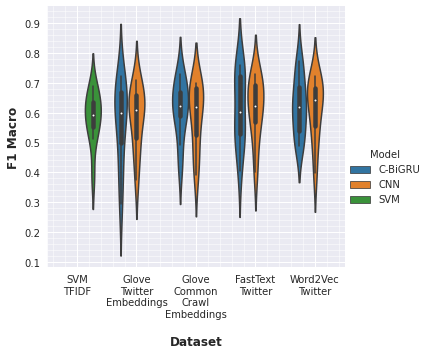

In [8]:
sns.set_style("darkgrid")
 
g = sns.catplot(x="Experiments", y="F1 Macro",
               data=data, kind="violin", hue="Model", order=order)

for ax in g.axes.flat:
    ax.get_xaxis().set_minor_locator(AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(AutoMinorLocator())
    ax.grid(visible=True, which='major', color='w', linewidth=1.0)
    ax.grid(visible=True, which='minor', color='w', linewidth=0.5)

xlabel('Dataset', fontsize=12, fontweight='bold')
ylabel('F1 Macro', fontsize=12, fontweight='bold')
plt.savefig(Path.joinpath(results_plot, "Incidence detection on different cities - Multi.pdf"))
plt.show()